In [231]:
import numpy as np
import matplotlib as mpl
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

In [232]:
'''
    Class for the SOM
    2D grid of weights that iteratively move toward regions of change of some function on spatical coords.
    Create the initial grid with the number of rows (ylength) and columns (xlength) you want, together
        with 4 points in a space of arbitrary dimensions.
        
    If vidims is an integer, then it will ignore anything > that number of latent dims for computing differences for visualization (e.g. the often one-hot conditioning parmaters which may not be used for SOM remapping anyway)

    To adjust the map,
    Iterate: getDifferences(values of neighbors) -> diffVect, -> update locations
''' 
class kmap:
    def __init__(self,   ylength,  xlength,  line0z0=np.array([0,0]), line0z1=np.array([0,1]), line1z0=np.array([1,0]), line1z1=np.array([1,1]), vizdims="all"):
        
        self.x, self.y = np.meshgrid(np.linspace(0,xlength-1, xlength, True), np.linspace(0, ylength-1, ylength, True))

        z = np.zeros((2, len(line0z0)))  #endpoints for each row      
        grid_z=[] # first append to list, then later stack to np.array

        # step orthogonal to the lines
        for i in np.linspace(0, 1, ylength, True):
            z[0,:]=(1-i)*line0z0 + i*line1z0
            z[1,:]=(1-i)*line0z1 + i*line1z1

            row_z = [] #  the pythonic way: first append to list, then later stack to np.array

            # step parallel to the lines
            for j in np.linspace(0, 1,  xlength, True) :
                p=(1-j)*z[0] + j*z[1]
                row_z.append(p)
            row_z=np.stack(row_z, axis=0)

            grid_z.append(row_z)
            
        #self.weights is the matrix of SOM "weights"
        self.weights = np.stack(grid_z, axis=0)
        print(f"weights.shape is {self.weights.shape}")
        
        # for visualization, weights on the 2D submanifold of the mesh
        if vizdims=="all" :
            vizdims=self.weights.shape[2]
        xspacing = np.linalg.norm(self.weights[0,1,:vizdims]-self.weights[0,0,:vizdims])
        yspacing = np.linalg.norm(self.weights[1,0:vizdims]-self.weights[0,0:vizdims])
        print(f"xspacing is {xspacing}. and yspacing is {yspacing}")
        self.weights2D=np.transpose(np.indices((ylength,xlength)),axes=(1,2,0))*np.array([xspacing, yspacing])
        print(f"weights2D.shape is {self.weights2D.shape}")
        

    
    def location(self, a, b) :
        return self.weights[a,b,:]
    
    #used for plotting
    #like np grid mesh, returns a 2D array of x values, and a 2D array of y values
    def locationMesh(self) :
        return self.weights[:,:,0], self.weights[:,:,1]
    
        
    '''
        returns a 2x2 matrix of vectors of length 8, with the differences between the value of a function at their respective weights 
        You can limit the non-zero mesh direction diffrerences with the dirs list (0 coresponds to 2pi, the reset index increments of Pi/4)
    '''         
    def getDifferences(self, vals, directions=[0,1,2,3,4,5,6,7], metric="L2") :
        #first duplicate values along the edges so we can roll. Implies diffs along edges will be 0.
        #assert vals.shape[:2] == self.weights.shape[:2], f"vals.shape={vals.shape}, but mesh shape is {self.weights.shape}"
        dirs=8 # counter clockwise in [0,360,step=45] . Redunant since links are symmetric        
        rows, cols = self.weights.shape[:2]
        rows=rows+2
        cols=cols+2
        vals=np.pad(vals, 1, mode='edge') # duplicate edge
        diff=np.zeros((rows,cols, dirs))
        
        rolldir=[(-1,0),(-1,-1),(0,-1),(1,-1),(1,0),(1,1),(0,1),(-1,1)]
    
        for d in directions : #range(dirs) :
            if len(vals.shape) > 2 :
                sumdims= tuple(range(2, len(vals.shape))) # if vals is not a scalar, sum over all the dimensions
                if metric == "L1" :
                     diff[:,:,d] = np.sum(np.abs(vals-np.roll(vals, rolldir[d], axis=(0,1))), axis=sumdims)
                else :
                    diff[:,:,d] = np.sqrt(np.sum(np.square(np.abs(vals-np.roll(vals, rolldir[d], axis=(0,1)))), axis=sumdims))
            else :
                diff[:,:,d] = np.abs(vals-np.roll(vals, rolldir[d], axis=(0,1)))
                                    
        return diff[1:rows-1,1:cols-1] # strip padding

        
    '''
    Turns vector of differences in 8 directions into a weightdims direction vector, the vector sum of the
        differences in each of the neighbor's directions
    '''
    def diffVect(self, wmatrix, diffs, clampedges=False, directions=[0,1,2,3,4,5,6,7] ) :
        
        #first duplicate values along the edges so we can roll. Means diffs along edges to outside neighbors will be 0.
        #assert vals.shape[:2] == self.weights.shape[:2], f"vals.shape={vals.shape}, but mesh shape is {self.weights.shape}"
        #dirs=8 # counter clockwise in [0,360,step=45] . Redunant since links are symmetric        
        rows, cols, weightdims = wmatrix.shape
        prows=rows+2
        pcols=cols+2
        
        #Pad weights (rows,cols,coordarray) with edge coordarrays
        pos= np.pad(wmatrix, ((1,1),(1,1),(0,0)), mode='edge') # duplicate edge so that difference in pos = 0 (tho doesn't matter if diffs in that direction is 0 anyway)
        #Pad diffs (rows, cols, [mags in each of 8 dims]) by duplicating the mag array along the edges
        diffs=np.pad(diffs,((1,1),(1,1),(0,0)), mode='edge')
        
        #roll *from* 0 degrees to 315 degrees incrementing by 45 degrees
        rolldir=[(-1,0),(-1,-1),(0,-1),(1,-1),(1,0),(1,1),(0,1),(-1,1)]
        
        # ----  first in the real high-D space -------------------------
        dv=np.zeros((prows,pcols, weightdims))
        
        
        
        # multiply difference between neighbors by the distance along the edge to the neighbor
        for d in directions : #range(dirs) :
            #roll one mesh unit in possibly both directions to get each of the eight neighbors
            neighborv=(np.roll(pos, rolldir[d], axis=(0,1))-pos)
            dv = dv + diffs[:,:,d,np.newaxis]*neighborv

        
        #print(f"New we have DV - the sum of all the mags in the eight different different directions. It's shape is {dv.shape}") 
        
        #OK, shave off the padding on dv
        dv=dv[1:rows+1,1:cols+1]

        if clampedges :
            # next, for the four edges of the 2D manifold, let's project dv onto the edge so they don't move of their lines.
            d0=wmatrix[0,cols-1]-wmatrix[0,0]
            d0unit=d0/np.linalg.norm(d0)
            dv[0,:] = np.multiply(np.dot(dv[0,:], d0)[:,np.newaxis], np.tile(d0unit, (cols,1)))

            d4=wmatrix[rows-1,cols-1]-wmatrix[rows-1,0]
            d4unit=d4/np.linalg.norm(d4)
            dv[rows-1,:] = np.multiply(np.dot(dv[rows-1,:], d4)[:,np.newaxis], np.tile(d4unit, (cols,1)))

            d2=wmatrix[rows-1,0]-wmatrix[0,0]
            d2unit=d2/np.linalg.norm(d2) 
            dv[:,0] = np.multiply(np.dot(dv[:,0], d2)[:,np.newaxis], np.tile(d2unit, (rows,1)))

            d6=wmatrix[rows-1,cols-1]-wmatrix[0,cols-1]
            d6unit=d6/np.linalg.norm(d6)
            dv[:,cols-1] = np.multiply(np.dot(dv[:,cols-1], d6)[:,np.newaxis], np.tile(d6unit, (rows,1)))
                   
                           
        #pin corners (not forgetting to remove padding first)
        dv[0,0]=dv[rows-1,0]= dv[0,cols-1]=dv[rows-1,cols-1]=np.zeros(weightdims)
           
        return dv

                  
    '''
        Move the weights along the direction vector by some increpemental step size
    '''
    
    def updateLocations(self, wmatrix, dv, step) :
        rows, cols, weightdims = wmatrix.shape
        
        #movable= np.full((rows,cols, weightdims), True, dtype=bool)
        #movable[0,0]=movable[rows-1,0]= movable[0,cols-1]=movable[rows-1,cols-1]= numpy.full((weightdims), False)
       # self.weights = np.where(movable, self.weights+step*dv, self.weights)        
        wmatrix = wmatrix+step*dv
        return wmatrix


# <span style="color:green"> SOM DEMO using "neighborhood differences" driving mesh adaptation </span>

In [233]:
'''
    To demonstrate/test the SOM, we'll create a some of two 2D gaussians on a plane to use as "values" of the SOM weights
'''
##### unsed to set dimension of mesh and of value array
ROWLENGTH = 20 # 7  #num cols
COLLENGTH = 20# 5  #num rows

#p1 =kmap(5,4,np.array([0,0]),np.array([0,3]),np.array([4,0]),np.array([4,3])) #( ylength (num rows), (xlength (num cols))
p1 =kmap(COLLENGTH,ROWLENGTH,np.array([-2, -2]),np.array([-2, 2]),np.array([2, -2]),np.array([2,2])) #( ylength (num rows), (xlength (num cols))
p1.weights.shape

weights.shape is (20, 20, 2)
xspacing is 0.21052631578947345. and yspacing is 0.2977291710259144
weights2D.shape is (20, 20, 2)


(20, 20, 2)

In [234]:
'''
    The plt arg is so we can plot the mesh on top of other plots
'''
def plotmesh(m,n, p=plt) : 
    p.scatter(m,n, color="black")

    segs1 = np.stack((m,n), axis=2)
    segs2 = segs1.transpose(1,0,2)
    p.gca().add_collection(LineCollection(segs1, colors='black'))
    p.gca().add_collection(LineCollection(segs2, colors='black'))
    p.show()  
    return p

In [235]:
'''
    For creating the 2D Gaussians
'''
# Mean vector and covariance matrix
mu2 = np.array([1.,-1])
Sigma2 = np.array([[ 1. , .8], [0.8,  1.]])

mu1 = np.array([-1.,1])
Sigma1 = np.array([[ 1. , -.8], [-.8,  1.]])


def multivariate_gaussian(x,y, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) # Note: unnormalized, with max=1


def two_Guassians(x,y, mu1, Sigma1, mu2, Sigma2):
    return multivariate_gaussian(x,y, mu1, Sigma1)+ multivariate_gaussian(x,y, mu2, Sigma2)

In [236]:
# Save the initial Guassian values over the evenly-spaced mesh before it moves
initX,initY = p1.locationMesh()
initZ = two_Guassians(initX, initY, mu1, Sigma1, mu2, Sigma2)

print(f"size of Z is {initZ.shape}")


size of Z is (20, 20)


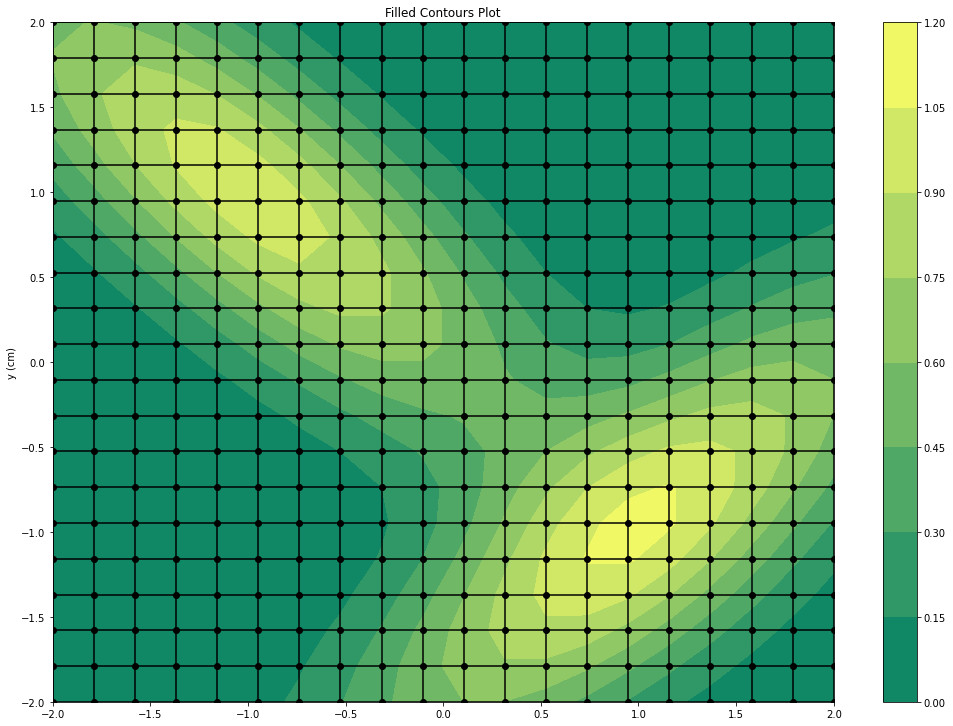

In [237]:
'''
    Plot the initial mesh weights over the function that will drive its evolution 
'''
cmap = "summer" #mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)

fig,ax=plt.subplots(1,1)
cp = ax.contourf(initX, initY, initZ, cmap=cmap)

fig.set_size_inches(17.5, 12.5)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')http://localhost:8889/notebooks/scratchbook/SOM.ipynb#
ax.set_ylabel('y (cm)')

plotmesh(initX,initY, plt)

plt.show()

In [238]:
'''
    HERE IS WHERE WE DO THE ITERATION
'''

# Let's make record of histograms of the spacing between mesh points since we want to see them 
#   approach a more uniform value. 

hgram=[]
hgramInterval=100
#hgramInterval=25

old_magsum=9999999999

for i in range(1001) :
#for i in range(501) :
    # get the new locations
    mX,mY = p1.locationMesh()
    # Compute the values of the functions at each node location 
    G = two_Guassians(mX,mY, mu1, Sigma1, mu2, Sigma2)
    
    # get the differences beteen the values at a node and it neighbors
   # diffm=p1.getDifferences(G, directions=[0,4])
    diffm=p1.getDifferences(G)
    
    # get the direction we want to move the mesh points
    dv=p1.diffVect(p1.weights, diffm, clampedges=True)
    dv2D=p1.diffVect(p1.weights2D, diffm, clampedges=True)
    
    magsum=np.sum(np.linalg.norm(dv2D, axis=2, keepdims=True))
    #print(f" sum of dv mags is {np.sum(np.linalg.norm(dv2D, axis=2, keepdims=True))}")
    print(f"{i}: change in magsum is {magsum-old_magsum}")
    old_magsum=magsum
    
    # update the mesh points
    p1.weights=p1.updateLocations(p1.weights, dv, .025)
    p1.weights2D=p1.updateLocations(p1.weights2D, dv2D, .025)
    

    
    # occaissionally save the histogram of differences between nodes
    if i%hgramInterval == 0 :
        #print(f"save histogrqam at step {i}")
        hgram.append(np.histogram(diffm[:,:], 12,(0,.2)))

    

0: change in magsum is -9999999973.36593
1: change in magsum is -0.9405289354507502
2: change in magsum is -0.8558099541319812
3: change in magsum is -0.7861679079171573
4: change in magsum is -0.7293289794589732
5: change in magsum is -0.6796617082805767
6: change in magsum is -0.634921778422946
7: change in magsum is -0.5981855597584911
8: change in magsum is -0.5603038944121259
9: change in magsum is -0.5262222153501135
10: change in magsum is -0.4975898874064413
11: change in magsum is -0.47020604840663793
12: change in magsum is -0.4473293126695026
13: change in magsum is -0.4258019607907997
14: change in magsum is -0.4091989206373938
15: change in magsum is -0.3921354186512147
16: change in magsum is -0.37192573027597575
17: change in magsum is -0.35412045819583327
18: change in magsum is -0.3380714416811639
19: change in magsum is -0.3230924013212899
20: change in magsum is -0.30908600777011763
21: change in magsum is -0.2959659487545103
22: change in magsum is -0.28365544250295

210: change in magsum is -0.008869549079646433
211: change in magsum is -0.008818511971496967
212: change in magsum is -0.00876819510224447
213: change in magsum is -0.00871857555174227
214: change in magsum is -0.008669627193578222
215: change in magsum is -0.008621319846683129
216: change in magsum is -0.008552089166469656
217: change in magsum is -0.008470338142782197
218: change in magsum is -0.00842440843653236
219: change in magsum is -0.00837892646921734
220: change in magsum is -0.008333824440422077
221: change in magsum is -0.008289021248375938
222: change in magsum is -0.008244419165972516
223: change in magsum is -0.008199899618132278
224: change in magsum is -0.008155318319296612
225: change in magsum is -0.008072472131917863
226: change in magsum is -0.00801798033795098
227: change in magsum is -0.00797261671598104
228: change in magsum is -0.007926412119925175
229: change in magsum is -0.007879326125006969
230: change in magsum is -0.007831592857685088
231: change in mags

423: change in magsum is -0.004076898113682503
424: change in magsum is -0.004064426827744327
425: change in magsum is -0.004052053488276641
426: change in magsum is -0.004039775318432692
427: change in magsum is -0.004027589785897234
428: change in magsum is -0.004015494573290201
429: change in magsum is -0.004003487551819784
430: change in magsum is -0.003991566758259069
431: change in magsum is -0.003979730374890966
432: change in magsum is -0.003967976711756638
433: change in magsum is -0.003956304191483184
434: change in magsum is -0.003944711335791329
435: change in magsum is -0.003933196753997059
436: change in magsum is -0.00392175913285131
437: change in magsum is -0.003910397227743001
438: change in magsum is -0.003899109855011851
439: change in magsum is -0.0038878958853376666
440: change in magsum is -0.0038767542378201902
441: change in magsum is -0.0038656838749284717
442: change in magsum is -0.003854683798059977
443: change in magsum is -0.003843753043563769
444: change

650: change in magsum is -0.002572442769589678
651: change in magsum is -0.0025643103548715906
652: change in magsum is -0.0025560859572424377
653: change in magsum is -0.0025476545259488503
654: change in magsum is -0.0025388410283628815
655: change in magsum is -0.0025297328190365675
656: change in magsum is -0.0025208644422467508
657: change in magsum is -0.0025124355985588487
658: change in magsum is -0.002504281462204272
659: change in magsum is -0.002496267083536008
660: change in magsum is -0.0024883308773677726
661: change in magsum is -0.0024804466065675435
662: change in magsum is -0.002472602711034888
663: change in magsum is -0.0024647939356698956
664: change in magsum is -0.0024570179187741736
665: change in magsum is -0.002449273711291333
666: change in magsum is -0.0024415610877390748
667: change in magsum is -0.0024338802044674424
668: change in magsum is -0.002426231420755709
669: change in magsum is -0.0024186152006446804
670: change in magsum is -0.002411032057144435

836: change in magsum is -0.0015631229935570978
837: change in magsum is -0.0015608746773323467
838: change in magsum is -0.0015586442453243698
839: change in magsum is -0.0015564310758735544
840: change in magsum is -0.001557277129990986
841: change in magsum is -0.001558431274049532
842: change in magsum is -0.001556192384916777
843: change in magsum is -0.0015539867722527134
844: change in magsum is -0.0015464179636044406
845: change in magsum is -0.0015389529014138148
846: change in magsum is -0.00153685815855642
847: change in magsum is -0.0015347899427116118
848: change in magsum is -0.0015327468170660552
849: change in magsum is -0.0015307274216347366
850: change in magsum is -0.0015287304686437686
851: change in magsum is -0.0015312988529707638
852: change in magsum is -0.0015401408526991567
853: change in magsum is -0.00153658912008936
854: change in magsum is -0.0015331256386632575
855: change in magsum is -0.0015297439992316697
856: change in magsum is -0.001526438310771816


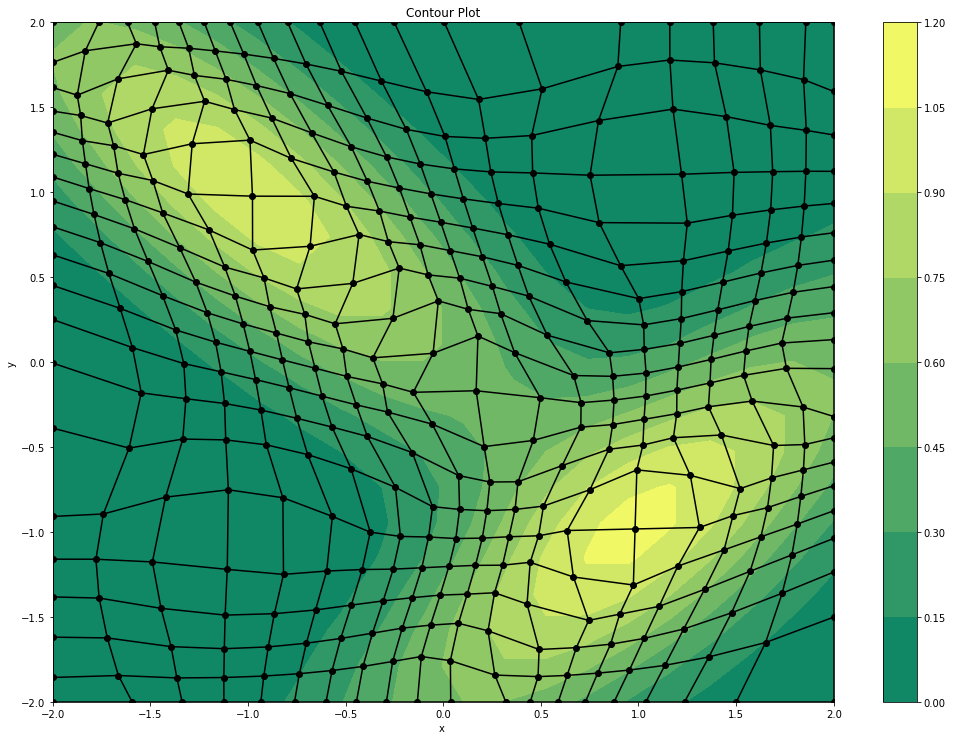

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [239]:
cmap = "summer" #mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)

fig,ax=plt.subplots(1,1)
fig.set_size_inches(17.5, 12.5)
cp = ax.contourf(initX, initY, initZ, cmap=cmap)  #original mesh to plot guassian

fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Contour Plot')
ax.set_xlabel('x ')
ax.set_ylabel('y ')

# get out mesh of node weights
m,n = p1.locationMesh()

##########   quiver
if False :
    A = m #np.arange(-10, 10, 1)
    B = n
    #U, V = np.meshgrid(X, Y)
    C=dv[:,:,0]
    D=dv[:,:,1]
    q=ax.quiver(A, B, C, D, linewidths=-1)
    ax.quiverkey(q, X=0.3, Y=1.1, U=100,
                 label='Quiver key, length = 10', labelpos='E')

##########
#Put the mesh on top of the values
plotmesh(m,n, plt)
#plt.show()

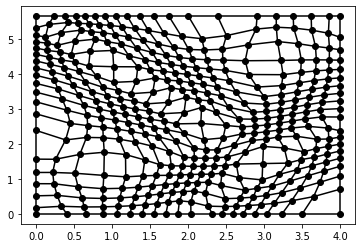

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [240]:
plotmesh(p1.weights2D[:,:,0], p1.weights2D[:,:,1],plt)

Text(0.5, 0, 'number of nodes in bin')

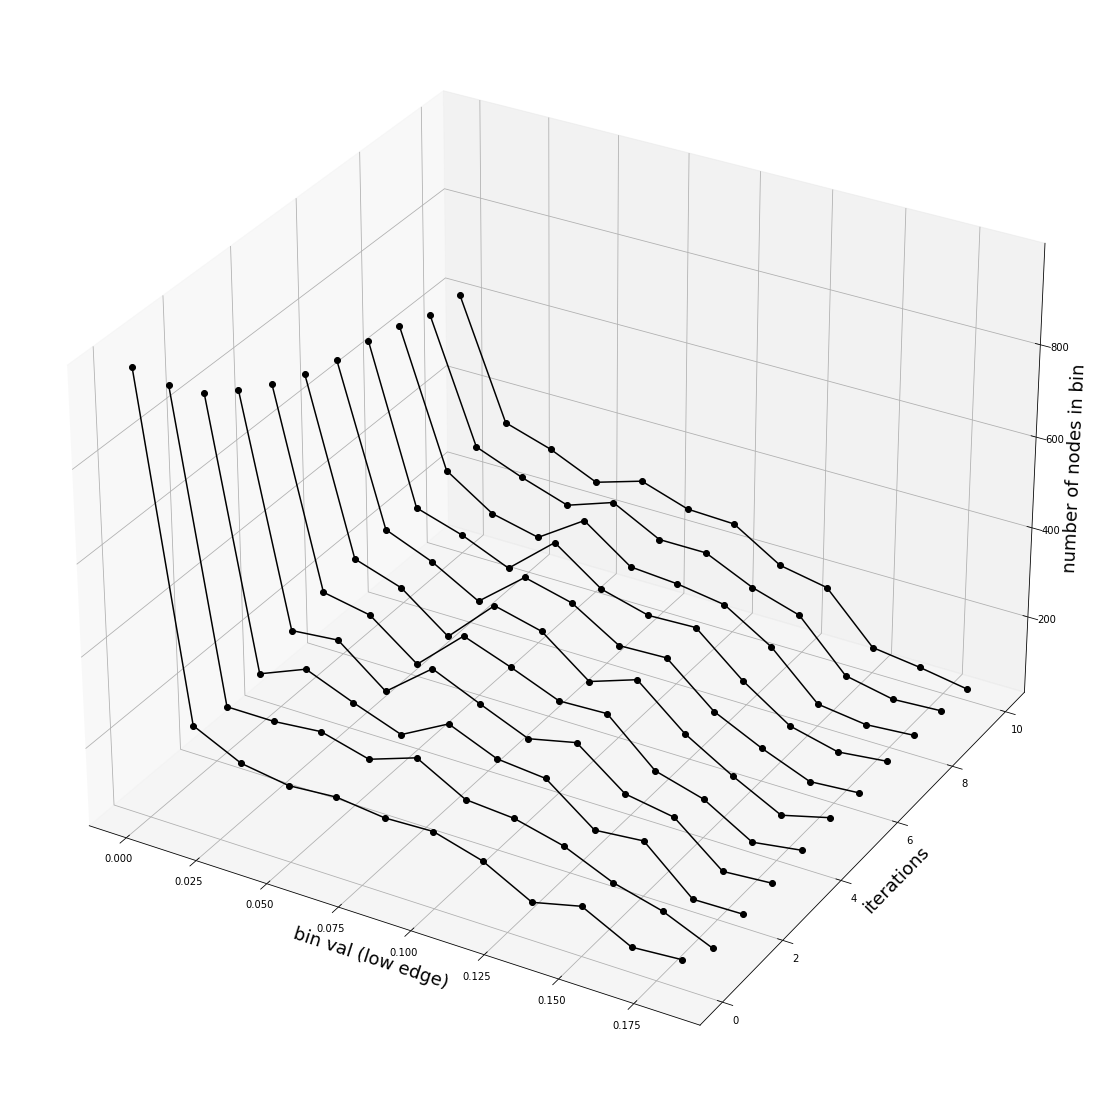

In [241]:
'''
    Plot the histograms of value differences between nodes over times
'''
#import matplotlib.pylab as pl
#from matplotlib import colors
#from mpl_toolkits.mplot3d import Axes3D


nbins=len(hgram[0][0])
nsteps=len(hgram)
y=np.zeros((nsteps, nbins))
z=np.zeros((nsteps, nbins))
x   = hgram[0][1][:nbins]  #bin center
for snum in range(0, nsteps) :
    y[snum]  = np.ones(nbins)*snum
    z[snum]   = hgram[snum][0]


fig1=plt.figure(figsize=(20,20))
#ax11=fig1.add_subplot(211,projection='3d')
ax11=fig1.add_subplot(111,projection='3d')

#ax = pl.subplot(projection='3d')
for snum in range(0, nsteps) :
    #ax11.plot(x, y[snum], z[snum], marker='o', color=colors.hsv_to_rgb([np.random.uniform(0, 1),.7,1]))
    ax11.plot(x, y[snum], z[snum], marker='o', color='#000000')


ax11.set_xlabel('bin val (low edge)', fontsize=18)
ax11.set_ylabel('iterations', fontsize=18)
ax11.set_zlabel('number of nodes in bin', fontsize=18) 

In [242]:
np.average(diffm[:,:])

0.07398820945977133

Text(0, 0.5, 'y ')

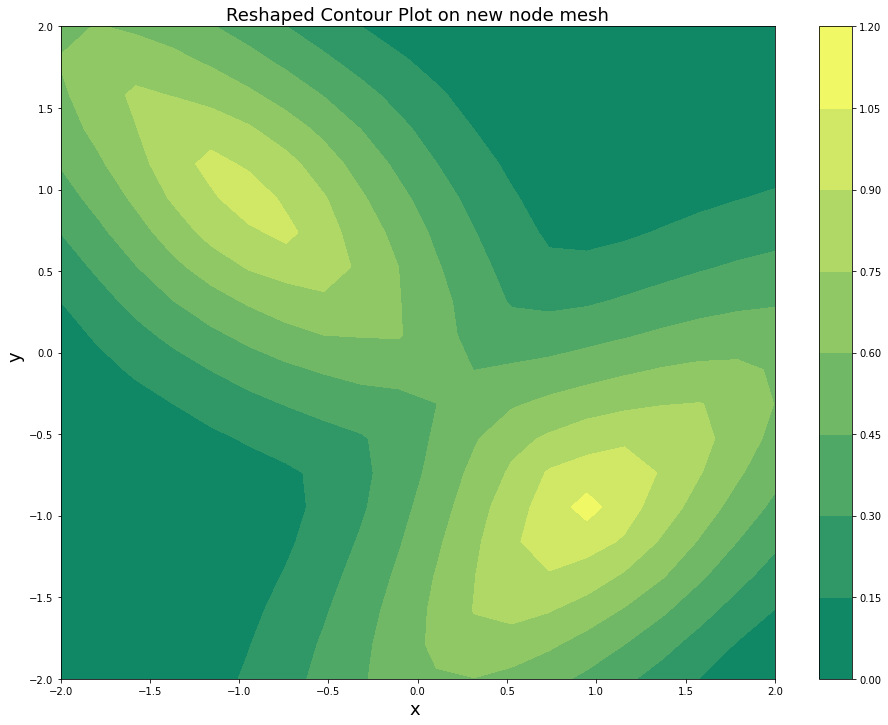

In [243]:
'''
    Stretch the mesh back out to put nodes on an evenly spaced grid, and show the value function. in this warped space. 
    Changes in the value function are now more evenly spaced. 
'''

cmap = "summer" #mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)


mX,mY = p1.locationMesh()
G = two_Guassians(mX,mY, mu1, Sigma1, mu2, Sigma2)



fig,ax=plt.subplots(1,1)
fig.set_size_inches(16, 12)
cp = ax.contourf(initX,initY, G, cmap=cmap)  #original mesh to plot guassian


fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Reshaped Contour Plot on new node mesh', fontsize=18)
ax.set_xlabel('x ', fontsize=18)
ax.set_ylabel('y ', fontsize=18)


#plotmesh(initX,initY, plt)

# <span style="color:green"> MESH ADAPTATION using trained GAN </span>

In [244]:
import os
from evaluation.gen_tests.generation_tests import StyleGEvaluationManager

In [245]:
from utils.utils import mkdir_in_path, load_model_checkp, saveAudioBatch, makesteps

In [246]:
'''
    Change the pitch value of a latent vector that is already concatenated with the dims for conditioned params
'''
def setPitch(z, evman, cparam="pitch", p_val=58) :
    if evman.att_dim > 0:
        z[ -evman.att_dim:] = torch.zeros(evman.att_dim)
    if evman.att_manager and cparam in evman.att_manager.keyOrder:
        p_att_dict = evman.att_manager.inputDict[cparam]
        p_att_indx = p_att_dict['order']
        p_att_size = evman.att_manager.attribSize[p_att_indx]
        try:
            p_indx = evman.att_manager.inputDict[cparam]['values'].index(p_val)
        except ValueError:
            p_indx = randint(p_att_size)

        z[ evman.latent_noise_dim + p_indx] = 1
        return z


### Set your PARAMs here

In [247]:
#####  PARAMS

dataset="nsynth.oreilly" 

if dataset=="oreilly2" :
    checkpointdir="output/oreilly2"

if dataset=="trumpinet" :
    checkpointdir="Keepers/nsynthsubsetmodel/output/outname_nsynthsubset_hop128_PGHI"

if dataset=="firecrowd_1sec" :
    checkpointdir="output/2021.05.04_firecrowd_try2/outname_firecrowd_hop128_PGHI"
    
if dataset=="nsynth.oreilly" :
    checkpointdir="output/nsynth.oreilly/nsynth_oreilly/outname_nsynthsubset_oreilly_hop128_PGHI"

model, config, model_name = load_model_checkp(checkpointdir)
eval_manager = StyleGEvaluationManager(model, n_gen=2)


if dataset=="oreilly2" :
    z0=torch.load('output/oreilly2/generation_tests/oreilly2_s4_i149970/random/2021-02-24 02:34/test_pitch_sweep_19.pt')
    z1=torch.load('output/oreilly2/generation_tests/oreilly2_s4_i149970/random/2021-02-24 02:34/test_pitch_sweep_21.pt')
    z2=torch.load('output/oreilly2/generation_tests/oreilly2_s4_i149970/random/2021-02-24 02:34/test_pitch_sweep_88.pt')
    z3=torch.load('output/oreilly2/generation_tests/oreilly2_s4_i149970/random/2021-02-24 02:34/test_pitch_sweep_89.pt')
    
    step=.00000001
    iterations=20001
    directions=[0,1,2,3,4,5,6,7]
    clampedges=True
    
    ylength=21
    xlength=21

if dataset=="trumpinet" :
    z0=torch.load('Keepers/nsynthsubsetmodel/output/outname_nsynthsubset_hop128_PGHI/generation_tests/outname_nsynthsubset_hop128_PGHI_s4_i299899/random/2021-04-24 10:13/test_pitch_sweep_45.pt')
    z1=torch.load('Keepers/nsynthsubsetmodel/output/outname_nsynthsubset_hop128_PGHI/generation_tests/outname_nsynthsubset_hop128_PGHI_s4_i299899/random/2021-04-24 10:13/test_pitch_sweep_45.pt')
    z2=torch.load('Keepers/nsynthsubsetmodel/output/outname_nsynthsubset_hop128_PGHI/generation_tests/outname_nsynthsubset_hop128_PGHI_s4_i299899/random/2021-04-24 10:13/test_pitch_sweep_26.pt')
    z3=torch.load('Keepers/nsynthsubsetmodel/output/outname_nsynthsubset_hop128_PGHI/generation_tests/outname_nsynthsubset_hop128_PGHI_s4_i299899/random/2021-04-24 10:13/test_pitch_sweep_26.pt')
    
    # All pitches p2.weights[n,:] (along the same row) will have the same pitch when the kmap class is instantiated.
    #z0=setPitch(z0, eval_manager, "pitch", 64)
    #z1=setPitch(z1, eval_manager, "pitch", 76)
    #z2=setPitch(z2, eval_manager, "pitch", 64)
    #z3=setPitch(z3, eval_manager, "pitch", 76)
    
    z0=setPitch(z0, eval_manager, "pitch", 64)
    z1=setPitch(z1, eval_manager, "pitch", 64)
    z2=setPitch(z2, eval_manager, "pitch", 64)
    z3=setPitch(z3, eval_manager, "pitch", 64)
    
    step=.0000005
    iterations=10001
    directions=[0,4]
    clampedges=True
    
    ylength=21
    xlength=13

    
if dataset=="firecrowd_1sec" :
    z0=torch.load('output/2021.05.04_firecrowd_try2/outname_firecrowd_hop128_PGHI/try2_fourcorners/test_pitch_sweep_4_fire.pt')
    z1=torch.load('output/2021.05.04_firecrowd_try2/outname_firecrowd_hop128_PGHI/try2_fourcorners/test_pitch_sweep_15_fire.pt')
    z2=torch.load('output/2021.05.04_firecrowd_try2/outname_firecrowd_hop128_PGHI/try2_fourcorners/test_pitch_sweep_65_crowd.pt')
    z3=torch.load('output/2021.05.04_firecrowd_try2/outname_firecrowd_hop128_PGHI/try2_fourcorners/test_pitch_sweep_0_crowd.pt') 
    
    step=.00000001
    iterations=20001
    directions=[0,1,2,3,4,5,6,7]
    clampedges=True
    
    ylength=21
    xlength=21
    
if dataset=="nsynth.oreilly" :
    z0=torch.load('output/nsynth.oreilly/nsynth_oreilly/outname_nsynthsubset_oreilly_hop128_PGHI/generation_tests/outname_nsynthsubset_oreilly_hop128_PGHI_s4_i299899/2D/2021-05-23 09:07/test_2D4pt_d1.2_d0.16_v.0.pt')
    z1=torch.load('output/nsynth.oreilly/nsynth_oreilly/outname_nsynthsubset_oreilly_hop128_PGHI/generation_tests/outname_nsynthsubset_oreilly_hop128_PGHI_s4_i299899/2D/2021-05-23 09:07/test_2D4pt_d1.2_d0.18_v.0.pt')
    z2=torch.load('output/nsynth.oreilly/nsynth_oreilly/outname_nsynthsubset_oreilly_hop128_PGHI/generation_tests/outname_nsynthsubset_oreilly_hop128_PGHI_s4_i299899/2D/2021-05-23 09:07/test_2D4pt_d1.3_d0.14_v.0.pt')
    z3=torch.load('output/nsynth.oreilly/nsynth_oreilly/outname_nsynthsubset_oreilly_hop128_PGHI/generation_tests/outname_nsynthsubset_oreilly_hop128_PGHI_s4_i299899/2D/2021-05-23 09:07/test_2D4pt_d1.5_d0.16_v.0.pt') 
    
    step=.00001
    iterations=2001
    directions=[0,1,2,3,4,5,6,7]
    clampedges=True
    
    ylength=21
    xlength=21
 

                


latentVectorDim (128) = noiseVectorDim (128) + categoryVectorDim_G (0)
PGAN: Building Generator

Size scale 0: [8, 8]

Checkpoint found at scale 4, iter 299899
PGAN: Building Generator

Size scale 0: (17, 8)

Average network found !


In [248]:
# OK, create the SOM instance
p2 =kmap(ylength,xlength,z0.cpu(),z1.cpu(),z2.cpu(),z3.cpu(), vizdims=eval_manager.latent_noise_dim) #( ylength (num rows), (xlength (num cols))
p2.weights.shape

weights.shape is (21, 21, 128)
xspacing is 0.07362536259629929. and yspacing is 0.555359939886819
weights2D.shape is (21, 21, 2)


(21, 21, 128)

In [249]:
p2.weights2D.shape

(21, 21, 2)

In [250]:
if checkpointdir == "Keepers/nsynthsubsetmodel/output/outname_nsynthsubset_hop128_PGHI" :
    for i in range(ylength) :
        for j in range(xlength) :
            p2.weights[i, j] = setPitch(p2.weights[i, j], eval_manager, "pitch", j+64)
    

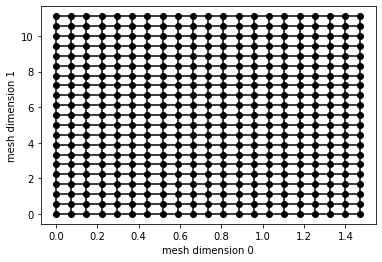

In [251]:
plt.xlabel("mesh dimension 0")
plt.ylabel("mesh dimension 1")
plotmesh(p2.weights2D[:,:,0], p2.weights2D[:,:,1])

origweights2D=p2.weights2D

In [252]:
batched_latents=torch.Tensor(p2.weights.reshape(ylength*xlength,p2.weights.shape[2]))
gen_batch = model.test(batched_latents, toCPU=True, getAvG=True)

In [253]:
gen_batch.shape

torch.Size([441, 1, 257, 128])

In [254]:
gen_batch=gen_batch.numpy().reshape(ylength,xlength,257,128)

In [255]:
gen_batch.shape

(21, 21, 257, 128)

In [ ]:
# PRE ADAPTATION  3D

# Let's see what the matrix of average distances between neighbors looks like before SOM linearization
spectdiff=p2.getDifferences(gen_batch, directions=directions)
pre_avgs=np.average(np.abs(spectdiff), axis=2)

#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt
#import numpy as np

X = np.arange(0, 21)
Y = np.arange(0, 21)
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.view_init(elev=15., azim=-360)
surf = ax.plot_surface(X, Y, pre_avgs, rstride=1, cstride=1, cmap='coolwarm', linewidth=0, antialiased=False)

fig.set_size_inches(12, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

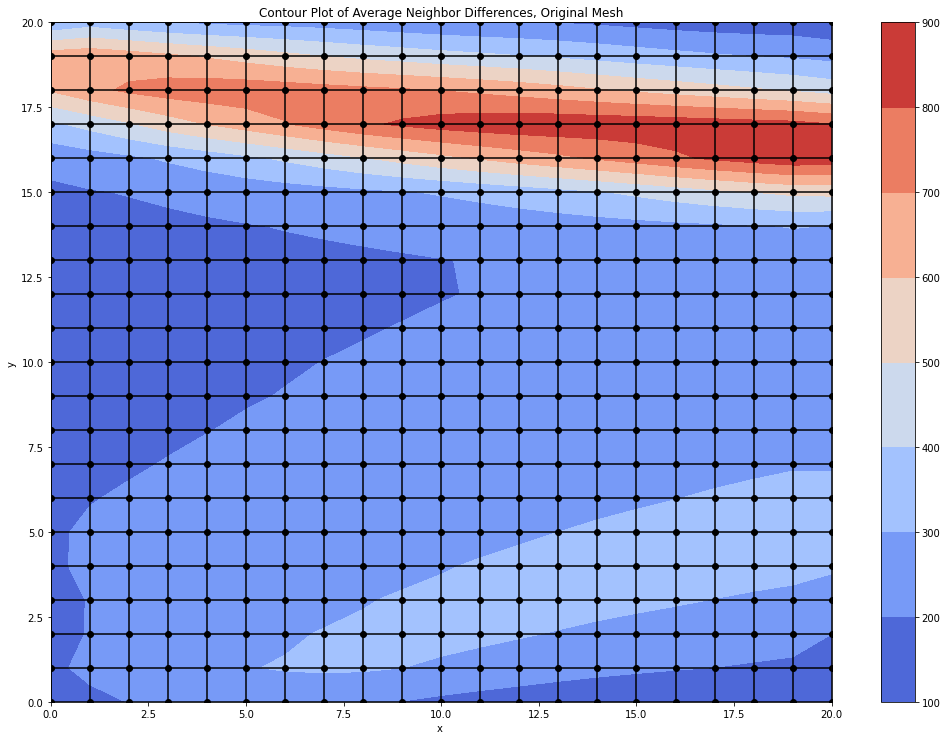

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [301]:
# PRE ADAPTATION CONTOUR

cmap = 'coolwarm' #mpl.cm.cool
#norm = mpl.colors.Normalize(vmin=5, vmax=10)

# get out mesh of node weights
X = np.arange(0, 21)
Y = np.arange(0, 21)
X, Y = np.meshgrid(X, Y)


fig,ax=plt.subplots(1,1)
fig.set_size_inches(17.5, 12.5)
cp = ax.contourf(X, Y, pre_avgs, cmap=cmap)  #original mesh to plot guassian

fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Average Neighbor Spectrogram Differences, Original Mesh')
ax.set_xlabel('x ')
ax.set_ylabel('y ')


##########
#Put the mesh on top of the values
plotmesh(X,Y, plt)
#plt.show()

finished iteration 0
0: change in magsum is -999934658.3818586


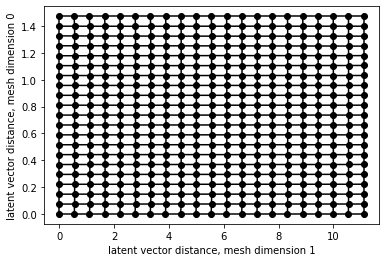

finished iteration 100
100: change in magsum is -55720.14058008981


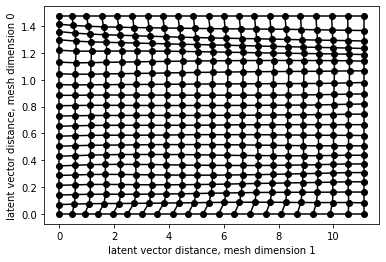

finished iteration 200
200: change in magsum is -2866.3896391991775


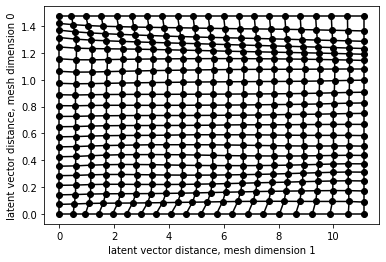

finished iteration 300
300: change in magsum is -1227.2411254097997


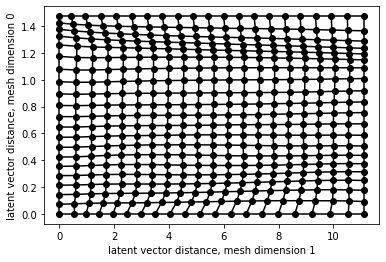

finished iteration 400
400: change in magsum is -782.3134773573674


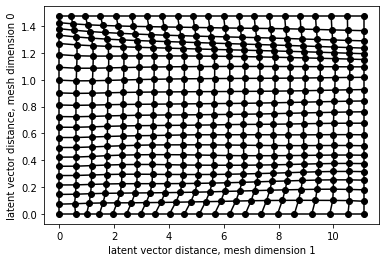

finished iteration 500
500: change in magsum is -515.2953910994902


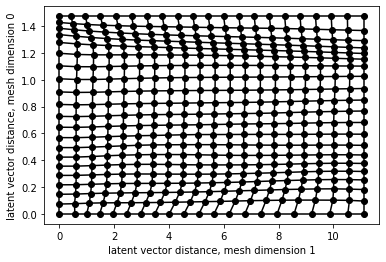

finished iteration 600
600: change in magsum is -374.06254045897094


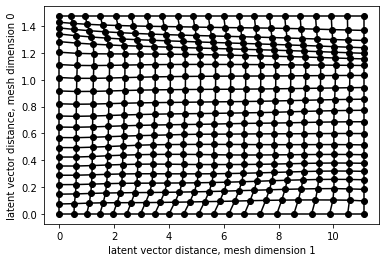

finished iteration 700
700: change in magsum is -322.1486905865295


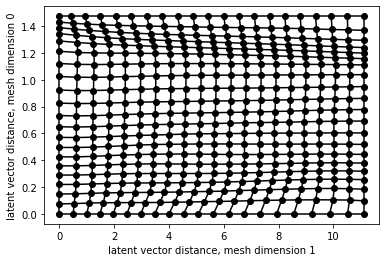

finished iteration 800
800: change in magsum is -188.61574315415965


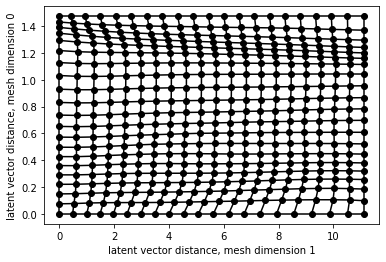

finished iteration 900
900: change in magsum is -158.86524198220513


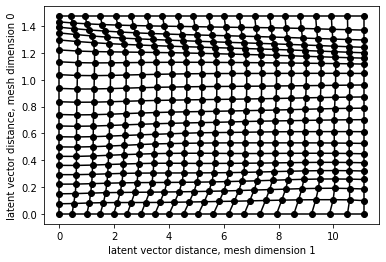

finished iteration 1000
1000: change in magsum is -33.12310050102815


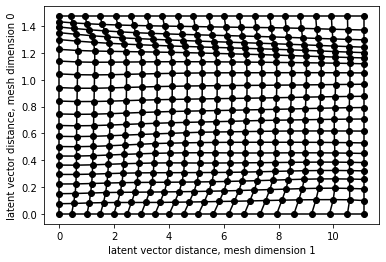

finished iteration 1100
1100: change in magsum is -38.069918479790886


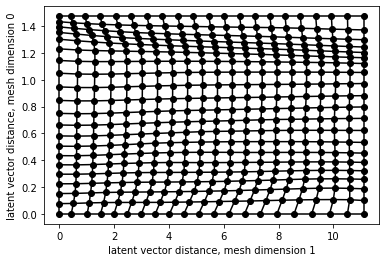

finished iteration 1200
1200: change in magsum is -13.903477785771884


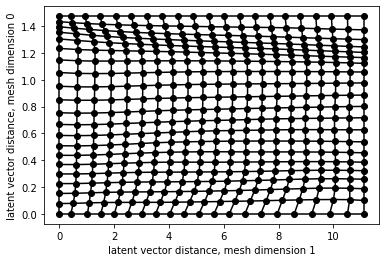

finished iteration 1300
1300: change in magsum is -48.0071900199473


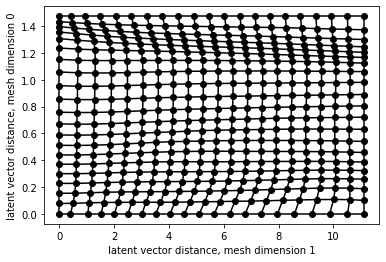

finished iteration 1400
1400: change in magsum is -26.522550210373993


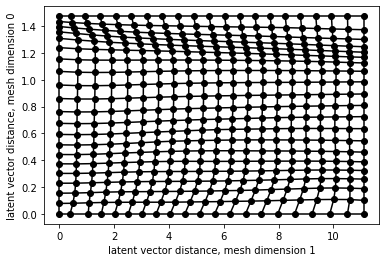

finished iteration 1500
1500: change in magsum is -32.25388706371632


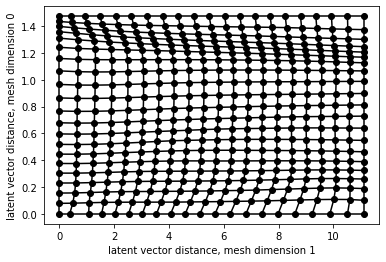

finished iteration 1600
1600: change in magsum is -30.402691677083567


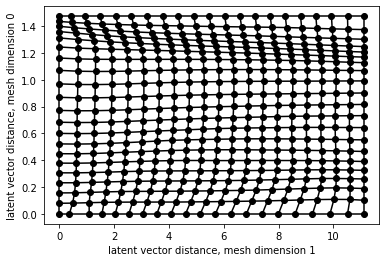

finished iteration 1700
1700: change in magsum is -29.322323483820583


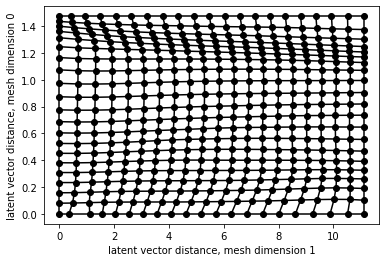

finished iteration 1800
1800: change in magsum is -65.12569476672161


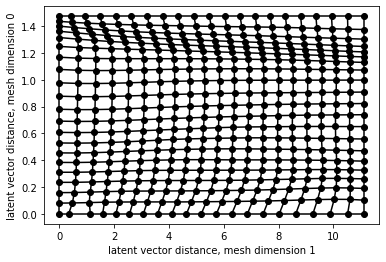

finished iteration 1900
1900: change in magsum is -30.693754350687414


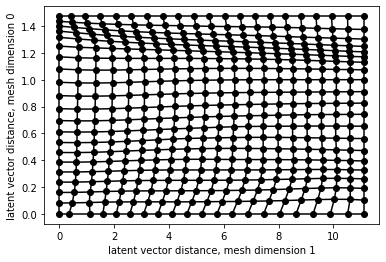

finished iteration 2000
2000: change in magsum is -50.04955426670949


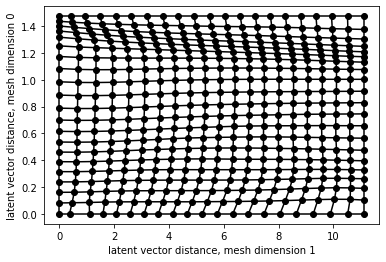

In [258]:
# Now do the SOM Linearization

hgram=[]
hgramInterval=100


old_magsum=999999999
#figure, ax = plt.subplots(figsize=(10, 8))

for i in range(iterations) :
    # get the new locations
    #mX,mY = p1.locationMesh()
    
    # Stack up weights into a single list for batch processing bythe GAN
    batched_latents=torch.Tensor(p2.weights.reshape(ylength*xlength,p2.weights.shape[2]))

    # Compute the values of the functions at each node location 
    #G = two_Guassians(mX,mY, mu1, Sigma1, mu2, Sigma2)
    gen_batch = model.test(batched_latents, toCPU=True, getAvG=True)
    gen_batch_npmatrix=gen_batch.numpy().reshape(ylength,xlength,257,128)
    
    # get the differences beteen the values at a node and it neighbors
    #diffm=p1.getDifferences(G)
    spectdiff=p2.getDifferences(gen_batch_npmatrix, directions=directions)
    
    # get the direction we want to move the mesh points
    dv=p2.diffVect(p2.weights, spectdiff, clampedges=clampedges, directions=directions)
    dv2D=p2.diffVect(p2.weights2D,spectdiff, clampedges=clampedges, directions=directions)
    
    # update the mesh points
    #p2.weights=p1.updateLocations(p2.weights, dv, step)
    #p2.weights2D=p1.updateLocations(p2.weights2D, dv2D, step)
    #CLAMPED EDGES REQUIRE SMALLER STEP SIZE TO AVOID NANs
    p2.weights=p2.updateLocations(p2.weights, dv, step)
    p2.weights2D=p2.updateLocations(p2.weights2D, dv2D, step)
    
    # occaissionally save the histogram of differences between nodes
    if i%hgramInterval == 0 :
        #print(f"save histogrqam at step {i}")
        hgram.append(np.histogram(diffm[:,:], 12,(0,.5)))
        print(f"finished iteration {i}")
        
        magsum=np.sum(np.linalg.norm(dv2D, axis=2, keepdims=True))
        #print(f" sum of dv mags is {np.sum(np.linalg.norm(dv2D, axis=2, keepdims=True))}")
        print(f"{i}: change in magsum is {magsum-old_magsum}")
        old_magsum=magsum
        
        plt.xlabel("latent vector distance, mesh dimension 1")
        plt.ylabel("latent vector distance, mesh dimension 0")
        plotmesh(p2.weights2D[:,:,1], p2.weights2D[:,:,0], plt)
        plt.pause(0.05)
    


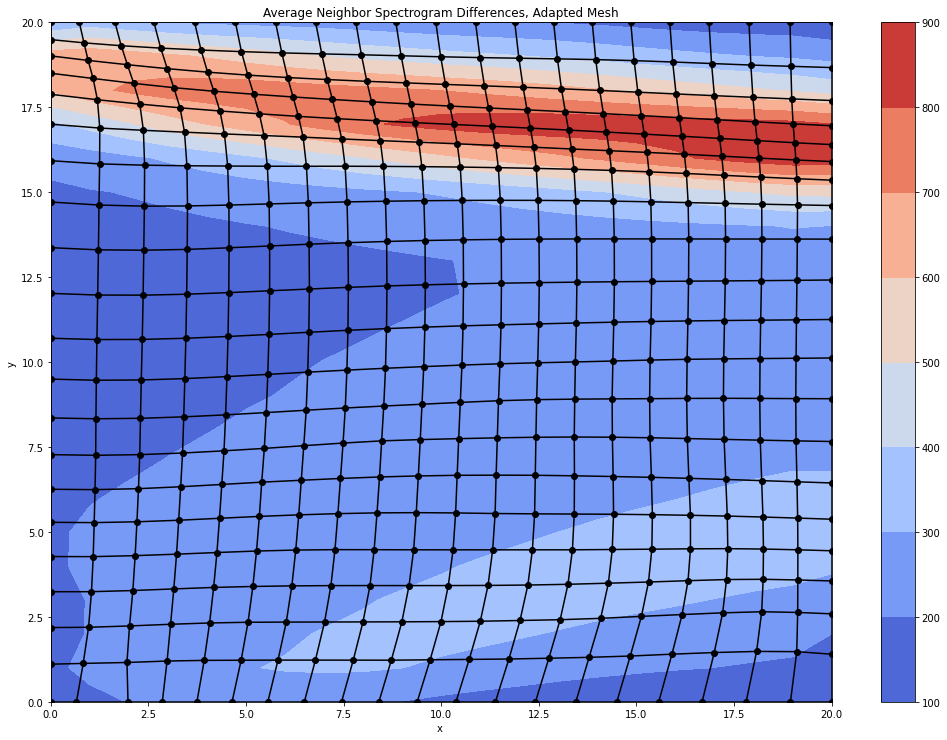

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [302]:

#POST ADAPTATION MESH on original contour


cmap = 'coolwarm' #mpl.cm.cool
norm = mpl.colors.Normalize(vmin=5, vmax=10)

# get out mesh of node weights
X = np.arange(0, 21)
Y = np.arange(0, 21)
X, Y = np.meshgrid(X, Y)


fig,ax=plt.subplots(1,1)
fig.set_size_inches(17.5, 12.5)
cp = ax.contourf(X, Y, pre_avgs, cmap=cmap)  #original mesh to plot guassian

fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title("Average Neighbor Spectrogram Differences, Adapted Mesh")
ax.set_xlabel('x ')
ax.set_ylabel('y ')


def map(x) :
    a=np.min(x)
    b=np.max(x)
    return 20*(x-a)/(b-a)
    
##########
#Put the mesh on top of the values
#plotmesh(X,Y, plt)
# get out mesh of node weights
#m,n = p2.locationMesh()
#p=np.min(m)
#plotmesh(map(m), n, plt)
plotmesh(map(p2.weights2D[:,:,1]), map(p2.weights2D[:,:,0]), plt)

In [259]:
gen_batch[0,0,:,:].shape

torch.Size([257, 128])

In [283]:
np.min(m)

-0.6596848368644714

In [260]:
np.amin(gen_batch.numpy()[:,0,:,:])

-56.558025

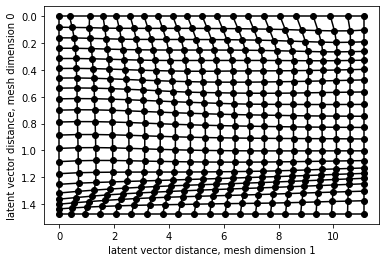

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [261]:
plt.xlabel("latent vector distance, mesh dimension 1")
plt.ylabel("latent vector distance, mesh dimension 0")
plt.gca().invert_yaxis()
plotmesh(p2.weights2D[:,:,1], p2.weights2D[:,:,0], plt)

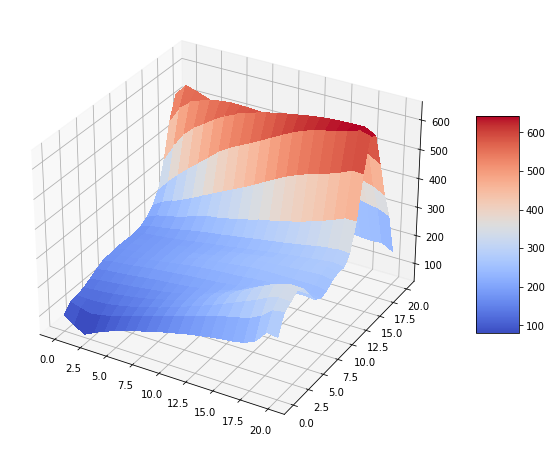

In [293]:
spectdiff=p2.getDifferences(gen_batch_npmatrix, directions=directions)
avgs=np.average(np.abs(spectdiff), axis=2)

#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.pyplot as plt
#import numpy as np

X = np.arange(0, 21)
Y = np.arange(0, 21)
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, avgs, rstride=1, cstride=1, cmap='coolwarm', linewidth=0, antialiased=False)

fig.set_size_inches(12, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


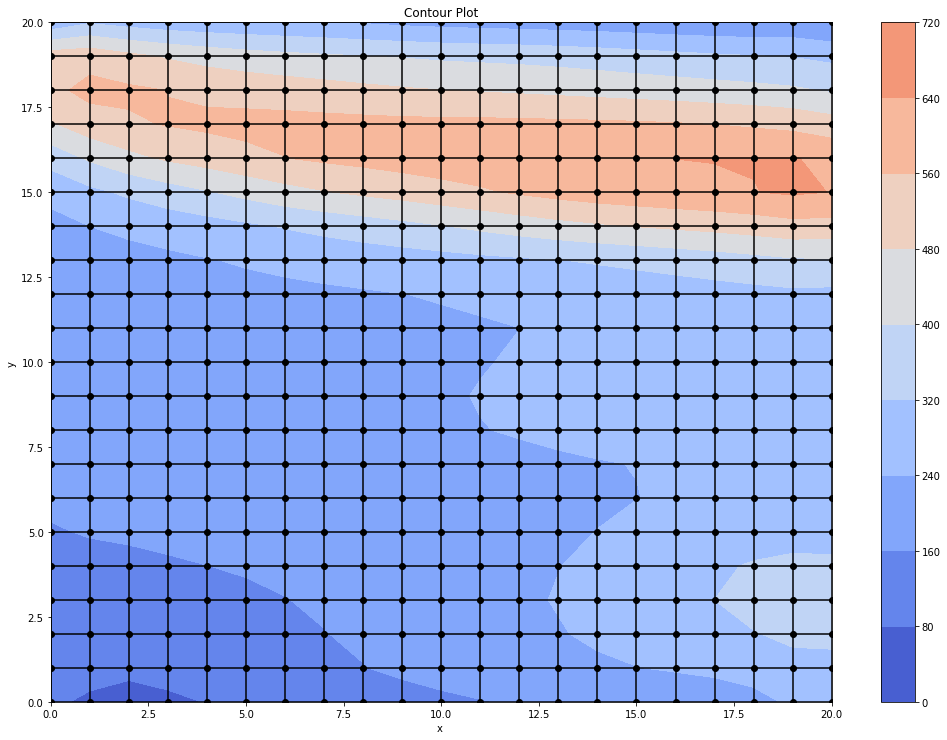

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [298]:
cmap = 'coolwarm' #mpl.cm.cool
#norm = mpl.colors.Normalize(vmin=5, vmax=10)

# get out mesh of node weights
X = np.arange(0, 21)
Y = np.arange(0, 21)
X, Y = np.meshgrid(X, Y)


fig,ax=plt.subplots(1,1)
fig.set_size_inches(17.5, 12.5)
cp = ax.contourf(X, Y, avgs, cmap=cmap, vmax=900)  #original mesh to plot guassian

fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Average Neighbor Spectrogram Differences, Repositioned Mesh')
ax.set_xlabel('x ')
ax.set_ylabel('y ')


##########
#Put the mesh on top of the values
plotmesh(X,Y, plt)
#plt.show()

In [264]:
avgs.shape

(21, 21)

In [265]:
p2.weights[4,9,:]

array([-0.57427299, -0.19018569,  0.08172094,  0.43072498, -0.11633104,
       -0.25864261,  0.05203604, -0.03589857,  1.21324606, -0.94877974,
        0.11228242, -0.31672478, -0.99775155, -0.74611319,  0.05349039,
       -0.31281339, -0.57032668,  0.17886735, -1.27739077,  2.03942233,
        0.38105342, -0.25718299,  0.26306216, -0.48044393, -0.53794691,
        0.4161854 , -0.85645151, -0.92059364, -0.24060303, -1.40919929,
       -0.12331221, -1.68934524, -0.03805149, -0.73741067,  0.50893643,
       -0.14192509,  1.19013765, -1.03023138,  1.62251841, -0.60991819,
        1.34625826,  0.67906641, -1.04064594, -0.17008078,  0.62186157,
        0.62391546, -0.78332011,  0.2356348 ,  1.42341574, -0.26802448,
        0.67395421,  0.22659684, -0.47142412, -0.61051146, -0.12276831,
       -0.14082096,  0.61850246,  0.40387647, -0.27786056,  0.86248986,
        0.39411987,  0.43174414, -1.32286232,  1.47735797, -0.06165264,
        0.57105561,  0.62995766, -0.37250118,  0.5844487 ,  1.17

Text(0.5, 0, 'number of nodes in bin')

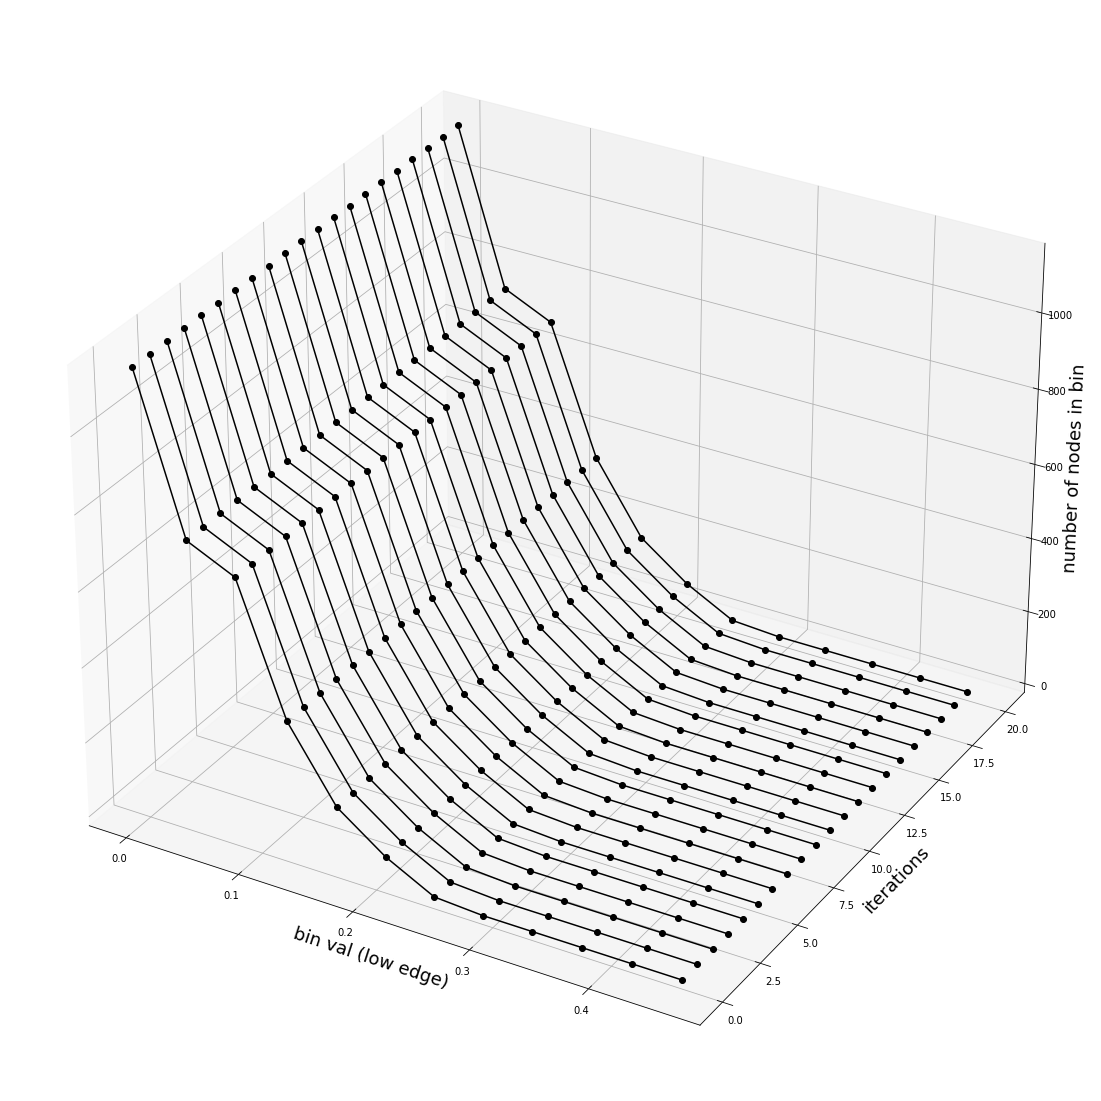

In [266]:
'''
    Plot the histograms of value differences between nodes over times
'''
#import matplotlib.pylab as pl
#from matplotlib import colors
#from mpl_toolkits.mplot3d import Axes3D
#import numpy as np

nbins=len(hgram[0][0])
nsteps=len(hgram)
y=np.zeros((nsteps, nbins))
z=np.zeros((nsteps, nbins))
x   = hgram[0][1][:nbins]  #bin center
for snum in range(0, nsteps) :
    y[snum]  = np.ones(nbins)*snum
    z[snum]   = hgram[snum][0]


fig1=plt.figure(figsize=(20,20))
#ax11=fig1.add_subplot(211,projection='3d')
ax11=fig1.add_subplot(111,projection='3d')

#ax = pl.subplot(projection='3d')
for snum in range(0, nsteps) :
    #ax11.plot(x, y[snum], z[snum], marker='o', color=colors.hsv_to_rgb([np.random.uniform(0, 1),.7,1]))
    ax11.plot(x, y[snum], z[snum], marker='o', color='#000000')


ax11.set_xlabel('bin val (low edge)', fontsize=18)
ax11.set_ylabel('iterations', fontsize=18)
ax11.set_zlabel('number of nodes in bin', fontsize=18) 

# SAVE the grid

In [267]:
# Here we save the who kitnkaboodle to a .pt file 
# To convert the pt file and write out the wave files and paramManager files for training an TNN afterwards, see
# the utilities/spectset2paramsound.py

if False :   #Change to True when you are ready to save your adapted grid
    outpath="output/nsynth.oreilly/SOMoutput"
    #outpath=checkpointdir + "/SOMgrid"
    if not os.path.exists(outpath):
        os.makedirs(outpath)

    torch.save((gen_batch,batched_latents), outpath+"/2021.05.24_nsynth.oreilly_lonce2.pt")

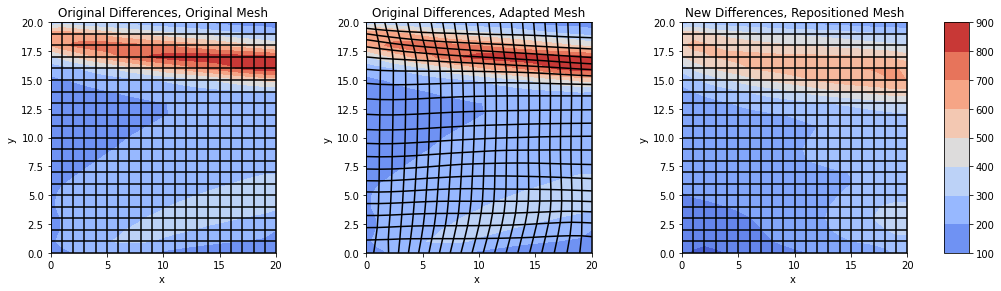

In [335]:
# This is just for generating a nice image 


def map(x) :
    a=np.min(x)
    b=np.max(x)
    return 20*(x-a)/(b-a)

cmap='coolwarm'
vmax=900
vmin=0

# get out mesh of node weights
X = np.arange(0, 21)
Y = np.arange(0, 21)
X, Y = np.meshgrid(map(X), map(Y))

fig = plt.figure()
fig.set_size_inches(17, 4)

ax = fig.add_subplot(131)
mesh = ax.contourf(X, Y, pre_avgs, cmap=cmap)  
mesh.set_clim(vmin,vmax)
ax.set_title('Original Differences, Original Mesh')
ax.set_xlabel('x ')
ax.set_ylabel('y ')

segs1 = np.stack((X,Y), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1, colors='black'))
plt.gca().add_collection(LineCollection(segs2, colors='black'))
#plt.scatter(X,Y, color="black")



# (b)
ax1 = fig.add_subplot(132)
mesh1 = ax1.contourf(X, Y, pre_avgs, cmap=cmap)
mesh1.set_clim(vmin,vmax)
ax1.set_title('Original Differences, Adapted Mesh')
ax1.set_xlabel('x ')
ax1.set_ylabel('y ')

#plotmesh(map(p2.weights2D[:,:,1]), map(p2.weights2D[:,:,0]), plt)
X_= map(p2.weights2D[:,:,1])
Y_ = map(p2.weights2D[:,:,0])
segs1 = np.stack((X_,Y_), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1, colors='black'))
plt.gca().add_collection(LineCollection(segs2, colors='black'))
#plt.scatter(X_,Y_, color="black")


# (c)

ax2 = fig.add_subplot(133)
mesh2 = ax2.contourf(X, Y, avgs, cmap=cmap)
mesh2.set_clim(vmin,vmax)
ax2.set_title('New Differences, Repositioned Mesh')
ax2.set_xlabel('x ')
ax2.set_ylabel('y ')

segs1 = np.stack((X,Y), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1, colors='black'))
plt.gca().add_collection(LineCollection(segs2, colors='black'))
#plt.scatter(X,Y, color="black")



fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.4, hspace=0.1)
cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(mesh, cax=cb_ax)

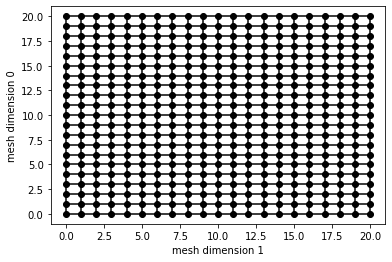

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [336]:
plt.xlabel("mesh dimension 1")
plt.ylabel("mesh dimension 0")
#plt.gca().invert_yaxis()
plotmesh(X, Y, plt)